# Alternative Tracing Methods

![AWTT](../../images/alternative_ways_to_trace_0.png)

So far in this module, we've taken a look at the traceable decorator, and how we can use it to set up tracing.

In this lesson, we're going to look at alternative ways in which we can set up tracing, and when you should think about using these different approaches.

## LangChain and LangGraph

If we are using LangChain or LangGraph, all we need to do to set up tracing is to set a few environment variables

![AWTT](../../images/alternative_ways_to_trace_1.png)

In [ ]:
# You can set them inline
import os
os.environ["OPENAI_API_KEY"] = ""
os.environ["LANGSMITH_API_KEY"] = ""
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langsmith-academy"  # If you don't set this, traces will go to the Default project

In [1]:
# Or you can use a .env file
from dotenv import load_dotenv
load_dotenv(dotenv_path="C:/Users/Lenovo/Documents/code/mat496/.env", override=True)

True

Don't worry too much about our graph implementation here, you can learn more about LangGraph through our LangGraph Academy course!

In [3]:
!pip install langgraph

  Using cached langgraph_checkpoint-2.1.1-py3-none-any.whl.metadata (4.2 kB)
  Using cached langgraph_prebuilt-0.6.4-py3-none-any.whl.metadata (4.5 kB)
Using cached langgraph_checkpoint-2.1.1-py3-none-any.whl (43 kB)
Using cached langgraph_prebuilt-0.6.4-py3-none-any.whl (28 kB)

   ------------- -------------------------- 2/6 [langgraph-sdk]
   --------------------------------- ------ 5/6 [langgraph]
   --------------------------------- ------ 5/6 [langgraph]
   --------------------------------- ------ 5/6 [langgraph]
   ---------------------------------------- 6/6 [langgraph]



USER_AGENT environment variable not set, consider setting it to identify your requests.


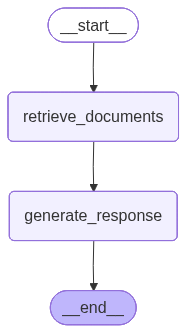

In [4]:
import nest_asyncio
import operator
from langchain.schema import Document
from langchain_core.messages import HumanMessage, AnyMessage, get_buffer_string
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from typing import List
from typing_extensions import TypedDict, Annotated
from utils import get_vector_db_retriever, RAG_PROMPT

nest_asyncio.apply()

retriever = get_vector_db_retriever()
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-exp", temperature=0)

# Define Graph state
class GraphState(TypedDict):
    question: str
    messages: Annotated[List[AnyMessage], operator.add]
    documents: List[Document]

# Define Nodes
def retrieve_documents(state: GraphState):
    messages = state.get("messages", [])
    question = state["question"]
    documents = retriever.invoke(f"{get_buffer_string(messages)} {question}")
    return {"documents": documents}

def generate_response(state: GraphState):
    question = state["question"]
    messages = state["messages"]
    documents = state["documents"]
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    
    rag_prompt_formatted = RAG_PROMPT.format(context=formatted_docs, conversation=messages, question=question)
    generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
    return {"documents": documents, "messages": [HumanMessage(question), generation]}

# Define Graph
graph_builder = StateGraph(GraphState)
graph_builder.add_node("retrieve_documents", retrieve_documents)
graph_builder.add_node("generate_response", generate_response)
graph_builder.add_edge(START, "retrieve_documents")
graph_builder.add_edge("retrieve_documents", "generate_response")
graph_builder.add_edge("generate_response", END)

simple_rag_graph = graph_builder.compile()
display(Image(simple_rag_graph.get_graph().draw_mermaid_png()))

We're setting up a simple graph in LangGraph. If you want to learn more about LangGraph, I would highly recommend taking a look at our LangGraph Academy course.

You can also pass in metadata or other fields through an optional config

In [5]:
question = "How do I set up tracing if I'm using LangChain?"
simple_rag_graph.invoke({"question": question}, config={"metadata": {"foo": "bar"}})

{'question': "How do I set up tracing if I'm using LangChain?",
 'messages': [HumanMessage(content="How do I set up tracing if I'm using LangChain?", additional_kwargs={}, response_metadata={}),
  AIMessage(content='To set up tracing with LangChain, you need to configure your environment and then log a trace. For more detailed information on configuration, you can refer to the Trace With LangChain guide.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-exp', 'safety_ratings': []}, id='run--14f38fc5-62ee-4698-892f-d59ae969cbae-0', usage_metadata={'input_tokens': 1383, 'output_tokens': 39, 'total_tokens': 1422, 'input_token_details': {'cache_read': 0}})],
 'documents': [Document(metadata={'id': '98f6e663-c725-46aa-b553-7018d7e46b37', 'changefreq': 'weekly', 'loc': 'https://docs.smith.langchain.com/observability/how_to_guides/trace_with_opentelemetry', 'priority': '0.5', 'sourc

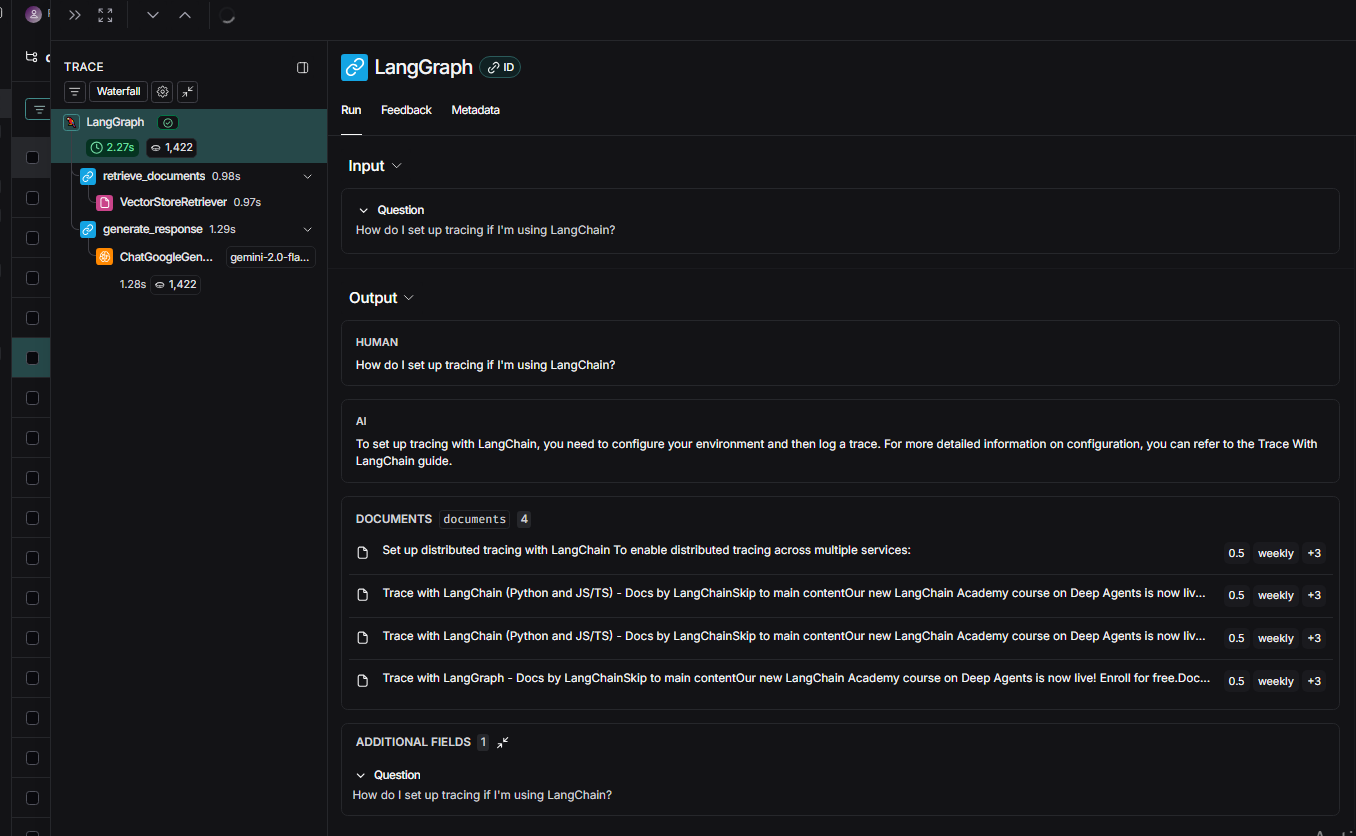

##### Let's take a look in LangSmith!

## Tracing Context Manager

In Python, you can use the trace context manager to log traces to LangSmith. This is useful in situations where:

You want to log traces for a specific block of code.
You want control over the inputs, outputs, and other attributes of the trace.
It is not feasible to use a decorator or wrapper.
Any or all of the above.
The context manager integrates seamlessly with the traceable decorator and wrap_openai wrapper, so you can use them together in the same application.

You still need to set your `LANGSMITH_API_KEY` and `LANGSMITH_TRACING`

![AWTT](../../images/alternative_ways_to_trace_2.png)

In [6]:
from langsmith import traceable, trace
from langchain_google_genai import ChatGoogleGenerativeAI
from typing import List
import nest_asyncio
from utils import get_vector_db_retriever

MODEL_PROVIDER = "google"
MODEL_NAME = "gemini-2.0-flash-exp"
APP_VERSION = 1.0
RAG_SYSTEM_PROMPT = """You are an assistant for question-answering tasks.
Use the following pieces of retrieved context to answer the latest question in the conversation.
If you don't know the answer, just say that you don't know.
Use three sentences maximum and keep the answer concise.
"""

llm = ChatGoogleGenerativeAI(model=MODEL_NAME, temperature=0.0)
nest_asyncio.apply()
retriever = get_vector_db_retriever()

"""
retrieve_documents
- Returns documents fetched from a vectorstore based on the user's question
"""
@traceable
def retrieve_documents(question: str):
    documents = retriever.invoke(question)
    return documents

"""
generate_response
- Calls `call_gemini` to generate a model response after formatting inputs
"""
def generate_response(question: str, documents):
    # NOTE: Our documents came in as a list of objects, but we just want to log a string
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)

    with trace(
        name="Generate Response",
        run_type="chain",
        inputs={"question": question, "formatted_docs": formatted_docs},
        metadata={"foo": "bar"},
    ) as ls_trace:
        messages = [
            {
                "role": "user",
                "content": f"{RAG_SYSTEM_PROMPT}\n\nContext: {formatted_docs}\n\nQuestion: {question}"
            }
        ]
        response = call_gemini(messages)
        ls_trace.end(outputs={"output": response})

    return response

"""
call_gemini
- Returns the chat completion output from Gemini
"""
@traceable
def call_gemini(
    messages: List[dict], model: str = MODEL_NAME, temperature: float = 0.0
) -> str:
    response = llm.invoke(messages)
    return response

"""
langsmith_rag
- Calls `retrieve_documents` to fetch documents
- Calls `generate_response` to generate a response based on the fetched documents
- Returns the model response
"""
@traceable
def langsmith_rag(question: str):
    documents = retrieve_documents(question)
    response = generate_response(question, documents)
    return response.content


In [7]:
question = "How do I trace with tracing context?"
ai_answer = langsmith_rag(question)
print(ai_answer)

To enable distributed tracing across multiple services, you can set up distributed tracing with LangChain. Tracing projects contain a significant amount of data. Filters are used for effectively navigating and analyzing this data.


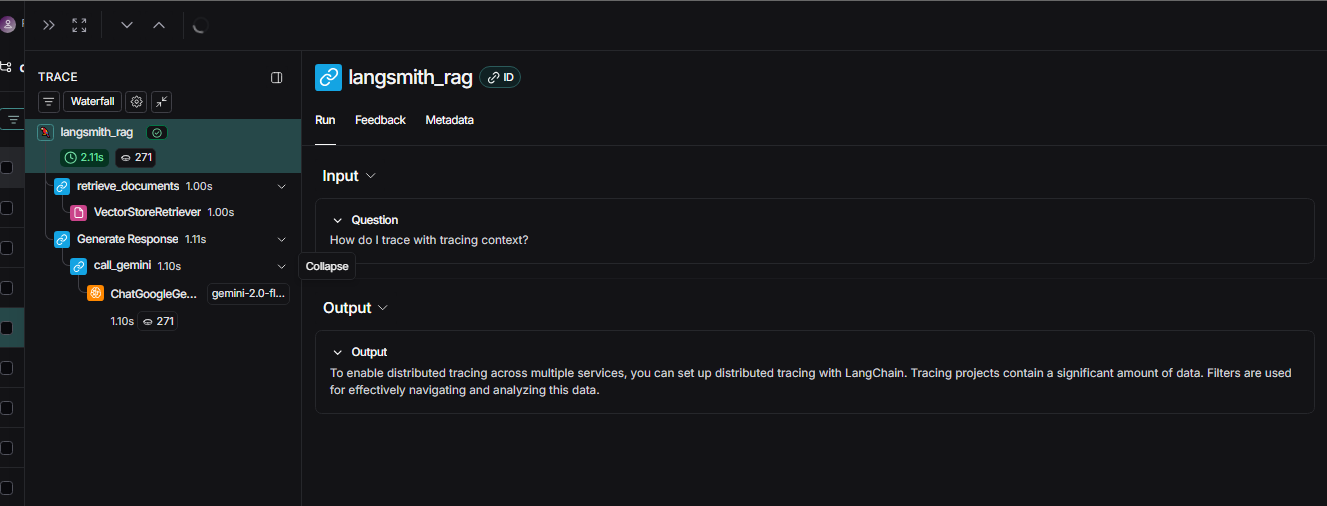

## wrap_openai

The wrap_openai/wrapOpenAI methods in Python/TypeScript allow you to wrap your OpenAI client in order to automatically log traces -- no decorator or function wrapping required! The wrapper works seamlessly with the @traceable decorator or traceable function and you can use both in the same application.

You still need to set your `LANGSMITH_API_KEY` and `LANGSMITH_TRACING`

![AWTT](../../images/alternative_ways_to_trace_3.png)

In [46]:
from langsmith.wrappers import wrap_openai
from langchain_google_genai import ChatGoogleGenerativeAI
from typing import List
import nest_asyncio
from utils import get_vector_db_retriever

MODEL_PROVIDER = "google"
MODEL_NAME = "gemini-2.0-flash-exp"
APP_VERSION = 1.0
RAG_SYSTEM_PROMPT = """You are an assistant for question-answering tasks.
Use the following pieces of retrieved context to answer the latest question in the conversation.
If you don't know the answer, just say that you don't know.
Use three sentences maximum and keep the answer concise.
"""

# Initialize Gemini Client
llm = ChatGoogleGenerativeAI(model=MODEL_NAME)

nest_asyncio.apply()
retriever = get_vector_db_retriever()

@traceable(run_type="chain")
def retrieve_documents(question: str):
    return retriever.invoke(question)

@traceable(run_type="chain")
def generate_response(question: str, documents):
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    messages = [
        {
            "role": "user",
            "content": f"{RAG_SYSTEM_PROMPT}\n\nContext: {formatted_docs}\n\nQuestion: {question}"
        }
    ]
    # LangChain models are automatically traced by LangSmith
    return call_gemini(messages)

def call_gemini(messages: List[dict]) -> str:
    return llm.invoke(messages)

@traceable(run_type="chain")
def langsmith_rag_with_wrap_gemini(question: str):
    documents = retrieve_documents(question)
    response = generate_response(question, documents)
    return response.content


In [47]:
question = "How do I trace with wrap_openai?"
ai_answer = langsmith_rag_with_wrap_gemini(question)
print(ai_answer)

To trace with `wrap_openai`, you can wrap your OpenAI client, which automatically logs traces without needing decorators. Ensure that the `LANGSMITH_TRACING` environment variable is set to 'true' and the `LANGSMITH_API_KEY` is configured. This setup ensures messages and tool calls are rendered nicely in LangSmith, and it works seamlessly with the `@traceable` decorator.


The wrapped OpenAI client accepts all the same langsmith_extra parameters as @traceable decorated functions

In [12]:
messages = [
    {
        "role": "user",
        "content": "What color is the sky?"
    }
]
llm.invoke(
    messages,
    config={"metadata": {"foo": "bar"}},
)

AIMessage(content='The sky appears blue on a clear day. This is due to a phenomenon called Rayleigh scattering, where shorter wavelengths of light (like blue and violet) are scattered more by the atmosphere than longer wavelengths (like red and orange).', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-exp', 'safety_ratings': []}, id='run--2acdbe74-1d54-40e5-aa35-6de4c95cb636-0', usage_metadata={'input_tokens': 6, 'output_tokens': 46, 'total_tokens': 52, 'input_token_details': {'cache_read': 0}})

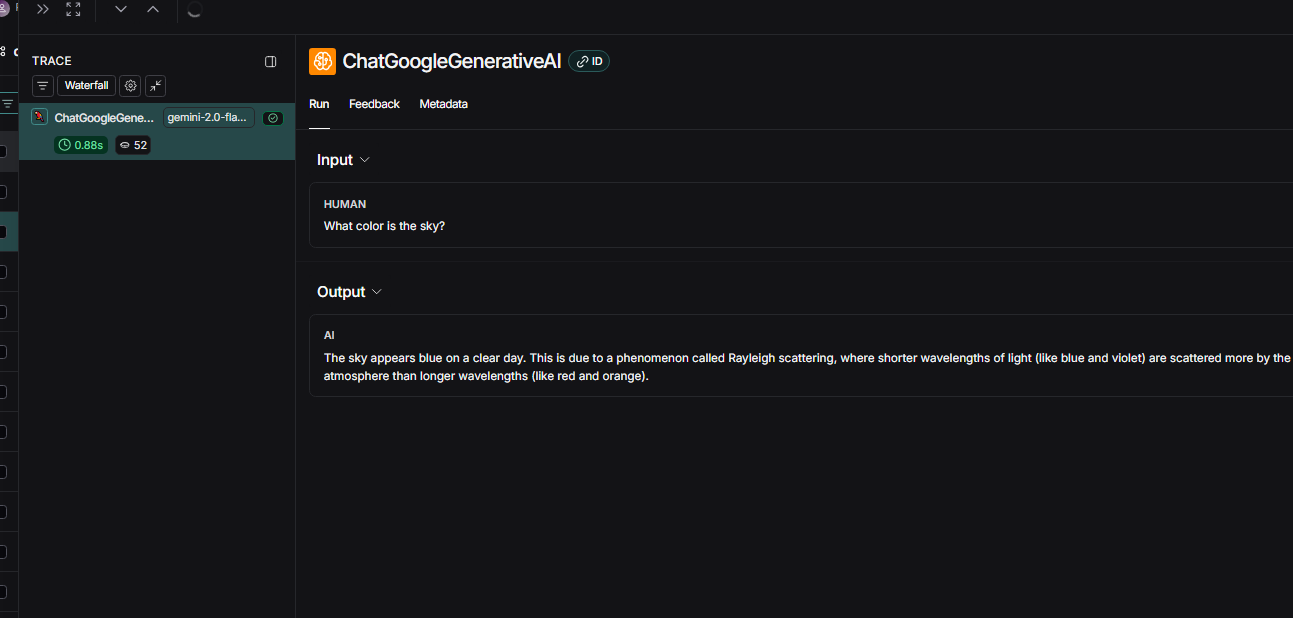

## [Advanced] RunTree

Another, more explicit way to log traces to LangSmith is via the RunTree API. This API allows you more control over your tracing - you can manually create runs and children runs to assemble your trace. You still need to set your `LANGSMITH_API_KEY`, but `LANGSMITH_TRACING` is not necessary for this method.

![AWTT](../../images/alternative_ways_to_trace_4.png)

In [ ]:
import os
os.environ["OPENAI_API_KEY"] = ""
os.environ["LANGSMITH_API_KEY"] = ""
os.environ["LANGSMITH_PROJECT"] = "langsmith-academy"

In [30]:
from dotenv import load_dotenv
# I have my env variables defined in a .env file
load_dotenv(dotenv_path="C:/Users/Lenovo/Documents/code/mat496/.env")

True

Let's go ahead and set `LANGSMITH_TRACING` to false, as we are using RunTree to manually create runs in this case.

In [35]:
import os
os.environ["LANGSMITH_TRACING"] = "false"
import langsmith as ls
import os


if 'LANGSMITH_TRACING' in os.environ:
    del os.environ['LANGSMITH_TRACING']
if 'LANGCHAIN_TRACING_V2' in os.environ:
    del os.environ['LANGCHAIN_TRACING_V2']

ls.configure(enabled=False)
from langsmith import utils
utils.tracing_is_enabled() # This should return false

False

We have rewritten our RAG application, except this time we pass a RunTree argument through our function calls, and create child runs at each layer. This gives our RunTree the same hierarchy that we were automatically able to establish with @traceable

In [45]:
from langsmith import RunTree
from langchain_google_genai import ChatGoogleGenerativeAI
from typing import List
import nest_asyncio
from utils import get_vector_db_retriever

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-exp")
nest_asyncio.apply()
retriever = get_vector_db_retriever()

def retrieve_documents(parent_run: RunTree, question: str):
    # Create a child run
    child_run = parent_run.create_child(
        name="Retrieve Documents",
        run_type="retriever",
        inputs={"question": question},
    )
    documents = retriever.invoke(question)
    # Post the output of our child run
    child_run.end(outputs={"documents": documents})
    child_run.post()
    return documents

def generate_response(parent_run: RunTree, question: str, documents):
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    rag_system_prompt = """You are an assistant for question-answering tasks.
    Use the following pieces of retrieved context to answer the latest question in the conversation.
    If you don't know the answer, just say that you don't know.
    Use three sentences maximum and keep the answer concise.
    """
    # Create a child run
    child_run = parent_run.create_child(
        name="Generate Response",
        run_type="chain",
        inputs={"question": question, "documents": documents},
    )
    messages = [
        {
            "role": "user",
            "content": f"{rag_system_prompt}\n\nContext: {formatted_docs}\n\nQuestion: {question}"
        }
    ]
    gemini_response = call_gemini(child_run, messages)
    # Post the output of our child run
    child_run.end(outputs={"gemini_response": gemini_response})
    child_run.post()
    return gemini_response

def call_gemini(parent_run: RunTree, messages: List[dict], model: str = "gemini-2.0-flash-exp", temperature: float = 0.0):
    # Create a child run
    child_run = parent_run.create_child(
        name="Gemini Call",
        run_type="llm",
        inputs={"messages": messages},
    )
    gemini_response = llm.invoke(messages)
    # Post the output of our child run
    child_run.end(outputs={"gemini_response": gemini_response})
    child_run.post()
    return gemini_response

def langsmith_rag(question: str):
    # Create a root RunTree
    root_run_tree = RunTree(
        name="Chat Pipeline",
        run_type="chain",
        inputs={"question": question}
    )

    # Pass our RunTree into the nested function calls
    documents = retrieve_documents(root_run_tree, question)
    response = generate_response(root_run_tree, question, documents)
    output = response.content

    # Post our final output
    root_run_tree.end(outputs={"generation": output})
    root_run_tree.post()
    return output

question = "How can I trace with RunTree?"
ai_answer = langsmith_rag(question)
print(ai_answer)

To trace with RunTree, you can use the `withRunTree` helper function. This function ensures that the run tree is propagated within traceable invocations. The server converts headers back to a run tree, which it uses to further continue the tracing.


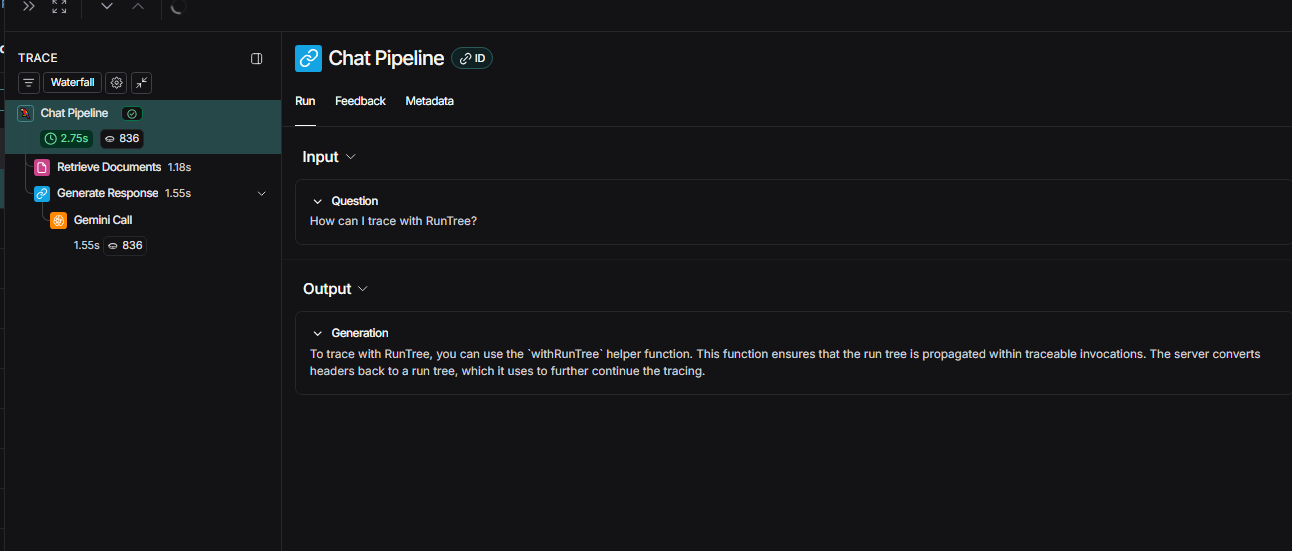